In [ ]:
### temas a consultar
"""

Modelo KMV (Kecholfer, McQuown y Vasicek)
Probit y Logit
survival analysis
PCA Curves
Score de credito
CDS, ABS, MBS, CDO

"""

### 1. Score de Credito

Considere un dataset con las siguientes caracteristicas:
+ Age: Edad de la persona
+ Annual_Income: Renta anual de la persona
+ Monthly_Inhand_Salary: Salario base mensual
+ Num_Bank_Accounts: Cantidad de cuentas bancarias que posee la persona
+ Num_Credit_Card: Cantidad de tarjetas de credito que posee la persona
+ Interest_Rate: Tasa de interes vigente para tarjetas de credito
+ Num_of_Loan: Numero de prestamos vigentes tomados por la persona
+ Delay_from_due_date: Numero de dias promedio de retraso al efectuar pagos
+ Num_of_Delayed_Payment: Promedio de pagos mensuales retrasados
+ Changed_Credit_Limit: Cambio porcentual en el cupo de las tarjetas
+ Num_Credit_Inquiries: Numero de reclamos de tarjetas
+ Credit_Mix: Clasificacion del portafolio de creditos
+ Outstanding_Debt: Deuda a pagar
+ Credit_Utilization_Ratio: Ratio de utilizacion de la tarjeta de credito
+ Credit_History_Age: Edad de historial crediticio
+ Payment_of_Min_Amount: Binaria, indica si la persona pago el monto minimo solamente
+ Total_EMI_per_month: cuota mensual fija en dolares
+ Amount_invested_monthly: Insersiones mensuales hecas por la persona
+ Monthly_Balance: Blance mensual de la persona
+ Credit_Score: Credit Score de la persona (Poor, Standard, Good)

In [7]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv("https://raw.githubusercontent.com/jisazac/pythonfinanzaseafit/master/Score.csv")
X=data.drop("Credit_Score",axis=1)
y=data["Credit_Score"]

numeric=X.select_dtypes(exclude="object").columns
categorical=['Payment_of_Min_Amount', 'Credit_Mix']

low_cardinality=[col for col in numeric if data[col].nunique()<=30]
high_cardinality=[col for col in numeric if data[col].nunique()>30]
#train=pd.read_csv("https://raw.githubusercontent.com/jisazac/pythonfinanzaseafit/master/modified_data.csv",encoding='latin')
#test=pd.read_csv("https://raw.githubusercontent.com/jisazac/pythonfinanzaseafit/master/test_score.csv",encoding='latin')

([<matplotlib.patches.Wedge at 0x299efc9a7c0>,
 [Text(-0.22995543576368635, 2.1879489248066863, 'Standard'),
  Text(-0.9571782015018224, -1.980860896320016, 'Poor'),
  Text(1.8699609717568793, -1.1589848851931024, 'Good')],
 [Text(-0.12543023768928344, 1.1934266862581924, '53.33%'),
  Text(-0.5220972008191759, -1.0804695798109176, '29.01%'),
  Text(1.0199787118673886, -0.6321735737416921, '17.66%')])

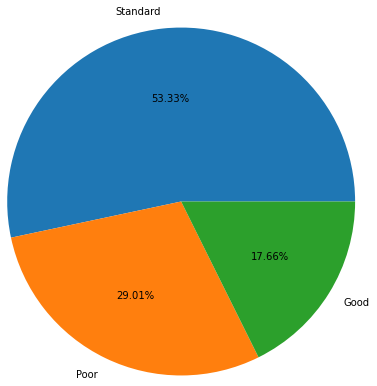

In [8]:
ser=data["Credit_Score"].value_counts()
plt.pie(x=ser.values, labels=ser.index, autopct="%0.2f%%", radius=2)

Existe una distribución desigual de clases en la variable objetivo, pero la diferencia de proporciones no es muy alta.

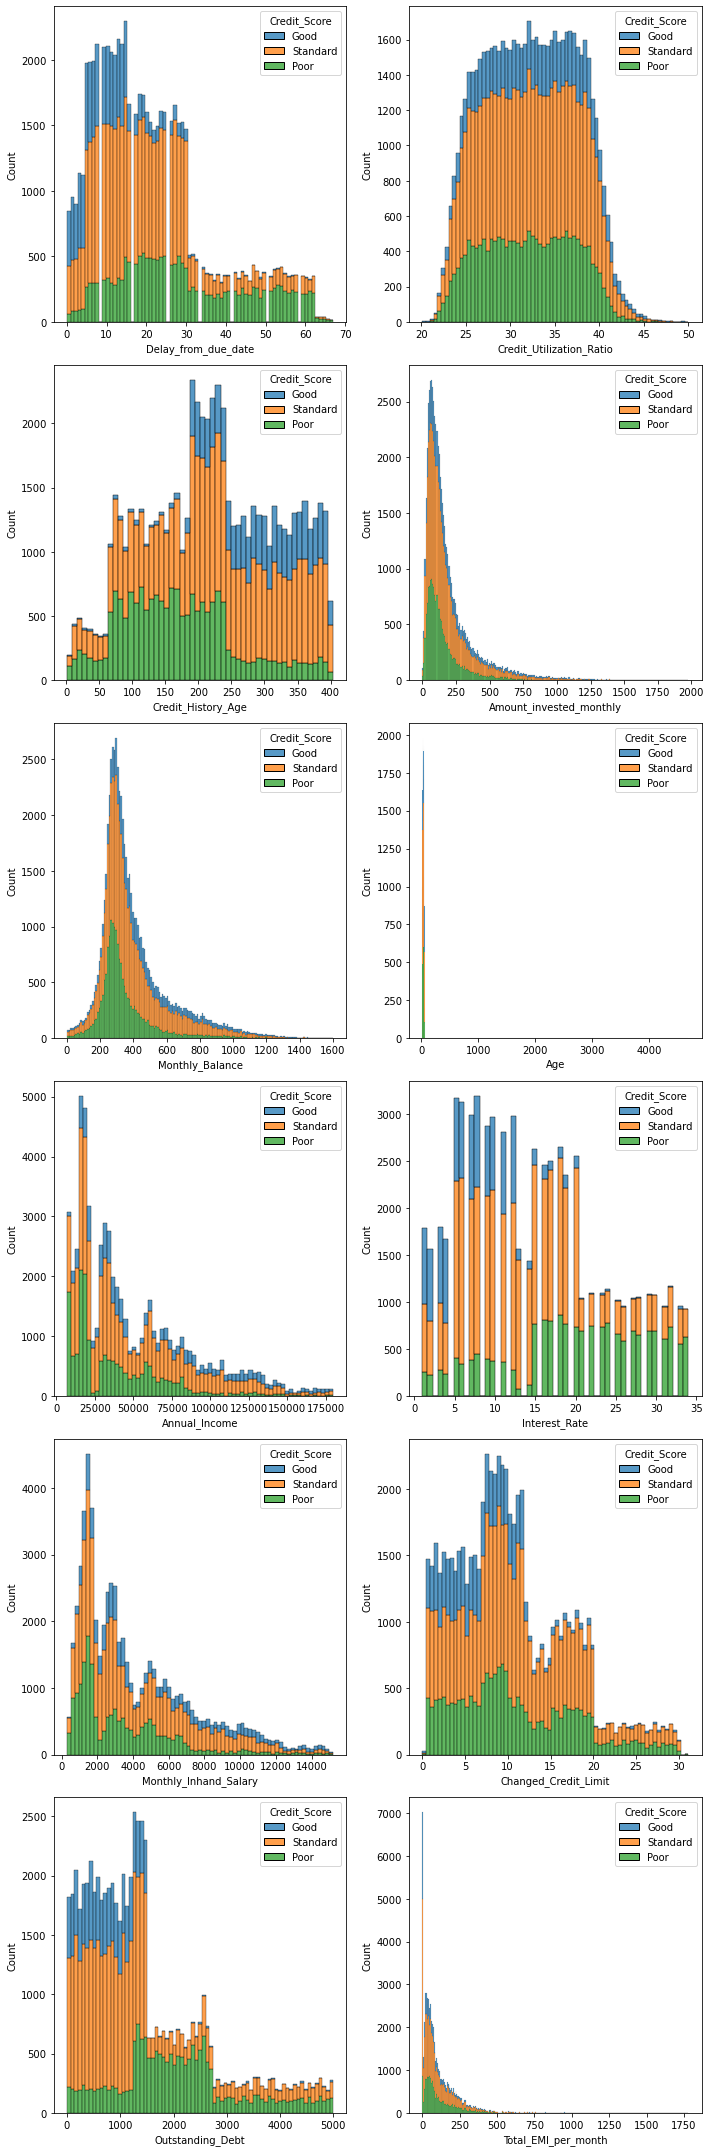

In [9]:
rows=[len(high_cardinality)//2 if len(high_cardinality)%2==0 else len(high_cardinality)//2+1]
fig,axes=plt.subplots(rows[0],2,figsize=(10,30))

ax=axes.flatten()
for i,col in enumerate(high_cardinality):
    sns.histplot(data=data,x=col,hue="Credit_Score",ax=ax[i],multiple="stack");
    
plt.tight_layout()

Vemos que para **Outstanding_Debt**,**Interest_Rate**,**Delay_from_due_date** Al aumentar los valores de esta variable  , la proporción de instancias de Mal Crédito (Bad Credit_Score) aumenta considerablemente, mientras que la proporción de instancias de Crédito Estándar (Standard) y Buen Crédito (Good Credit_Score) se vuelve escasa.

Por otro lado, el aumento en **Credit_History_Age** (Antigüedad del historial crediticio) y la **Edad** (Age) resulta en una disminución de las instancias de Mal Crédito (Bad Credit_Score) y un aumento en las instancias de Crédito Estándar (Standard) y Buen Crédito (Good Credit_Score).

Curiosamente, la relación de utilización de crédito (credit_utilization_ratio) parece tener la misma distribución para todas las categorías de puntaje de crédito.
La distribución de muchas características no sigue una distribución gaussiana y tiene escalas muy diferentes, por lo tanto, transformaremos las variables de características.

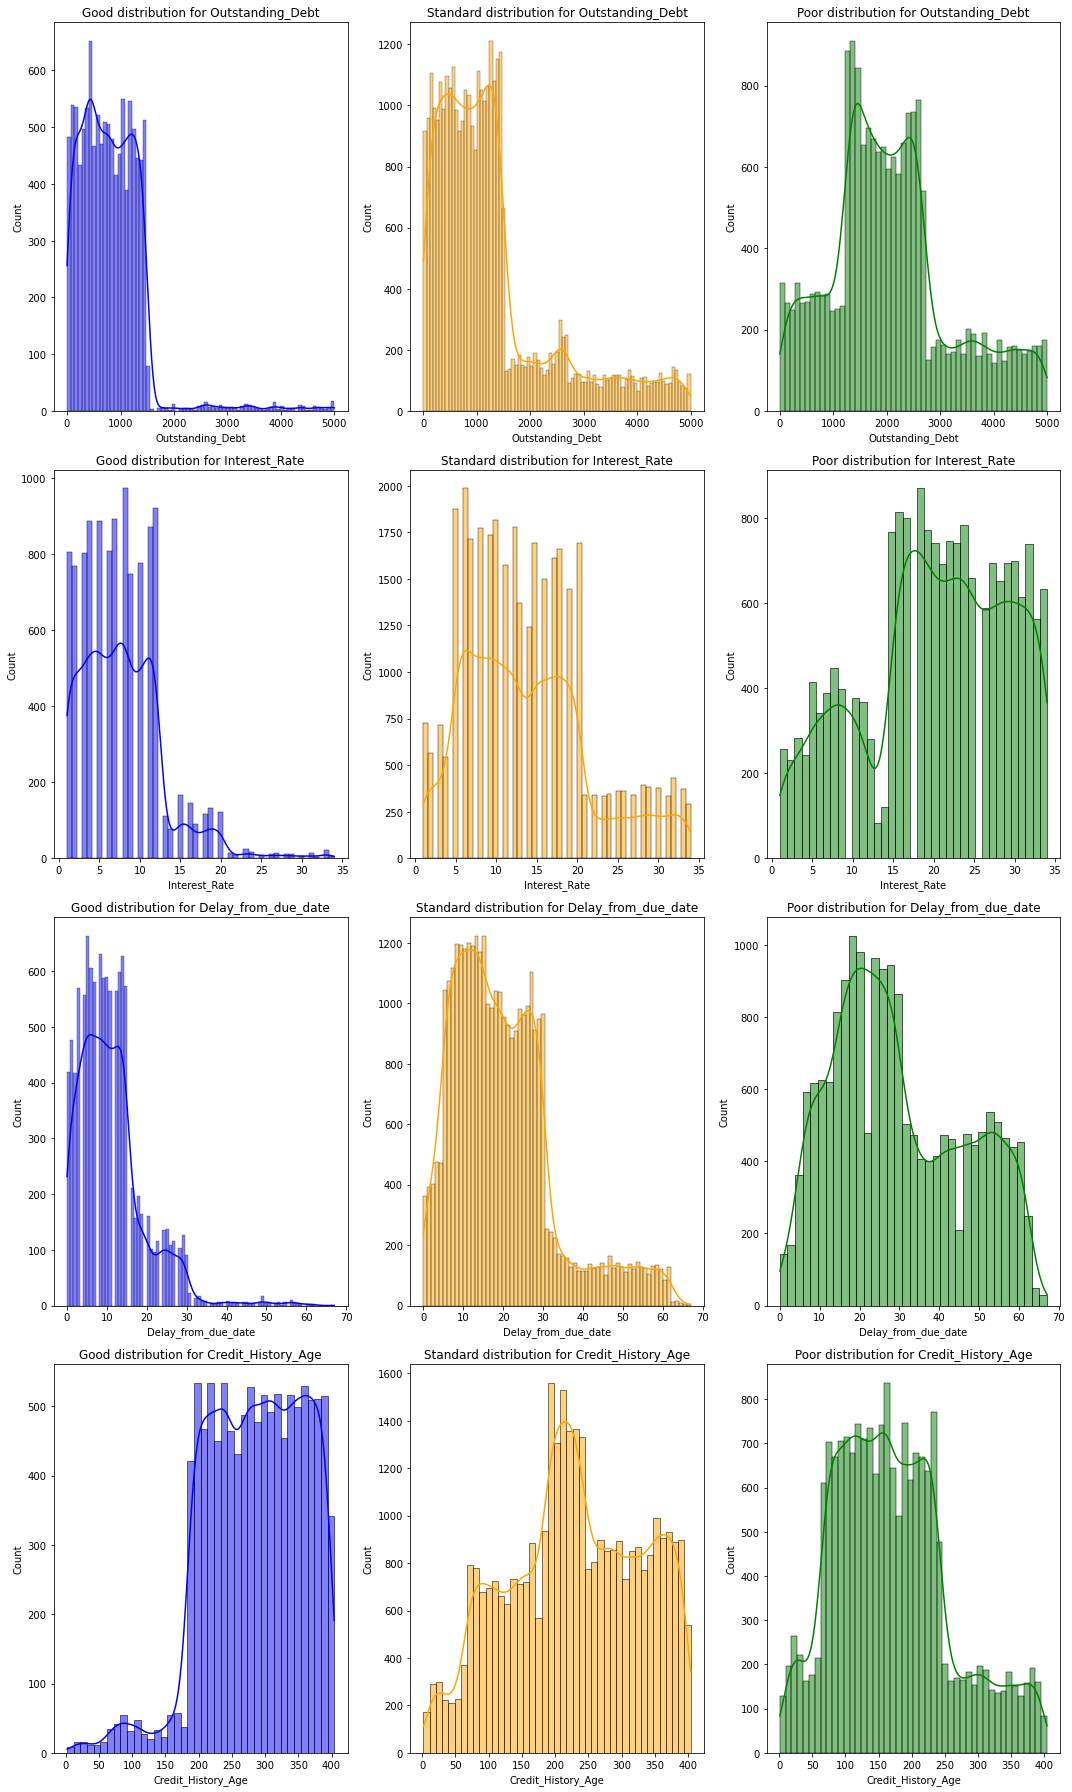

In [10]:
cols=["Outstanding_Debt", "Interest_Rate", "Delay_from_due_date", "Credit_History_Age"]
vals=["Good","Standard","Poor"]
colors=["blue","orange","green"]

fig,axes=plt.subplots(len(cols),3,figsize=(15,25))

for i,col in enumerate(cols):
    for j,(val,color) in enumerate(zip(vals,colors)):
        ax=axes[i,j]
        inter=data[data["Credit_Score"]==val]
        sns.histplot(data=inter,x=col,ax=ax,color=color,kde=True);
        ax.set_title(f"{val} distribution for {col}")
    
plt.tight_layout()

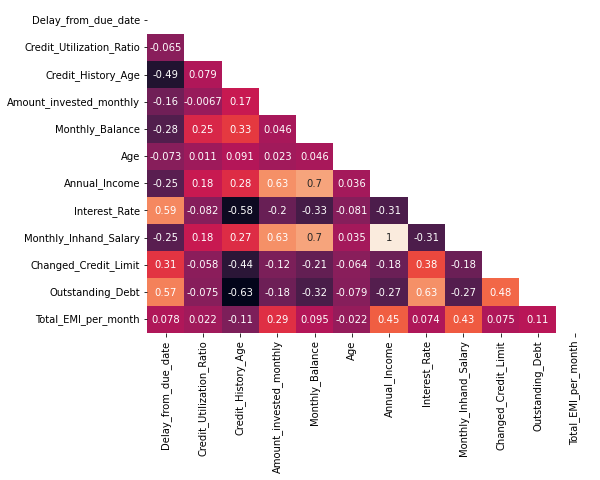

In [11]:
plt.figure(figsize=(8, 6))
arr=np.ones_like(data[high_cardinality].corr())
mask=np.triu(arr)
sns.heatmap(data[high_cardinality].corr(), cbar=False, annot=True, fmt=".2g", mask=mask);


Muchas variables tienen una fuerte correlación con otras, por ejemplo, **delay_from_due_date** tiene una fuerte correlación positiva con la tasa de interés cobrada (0.59), **outstanding_debt** (0.57) y una fuerte correlación negativa con **Credit_History_Age** (-0.49) y **Monthly_Inhand_Salary** (-0.25).

Así, una persona que ha tomado una gran suma de dinero a una tasa de interés alta con un salario bajo, disciplina financiera y ahorros escasos es más propensa a tener un alto número de pagos atrasados, buscar más crédito para pagar préstamos, lo que resulta en una tasa de interés alta y una deuda grande.



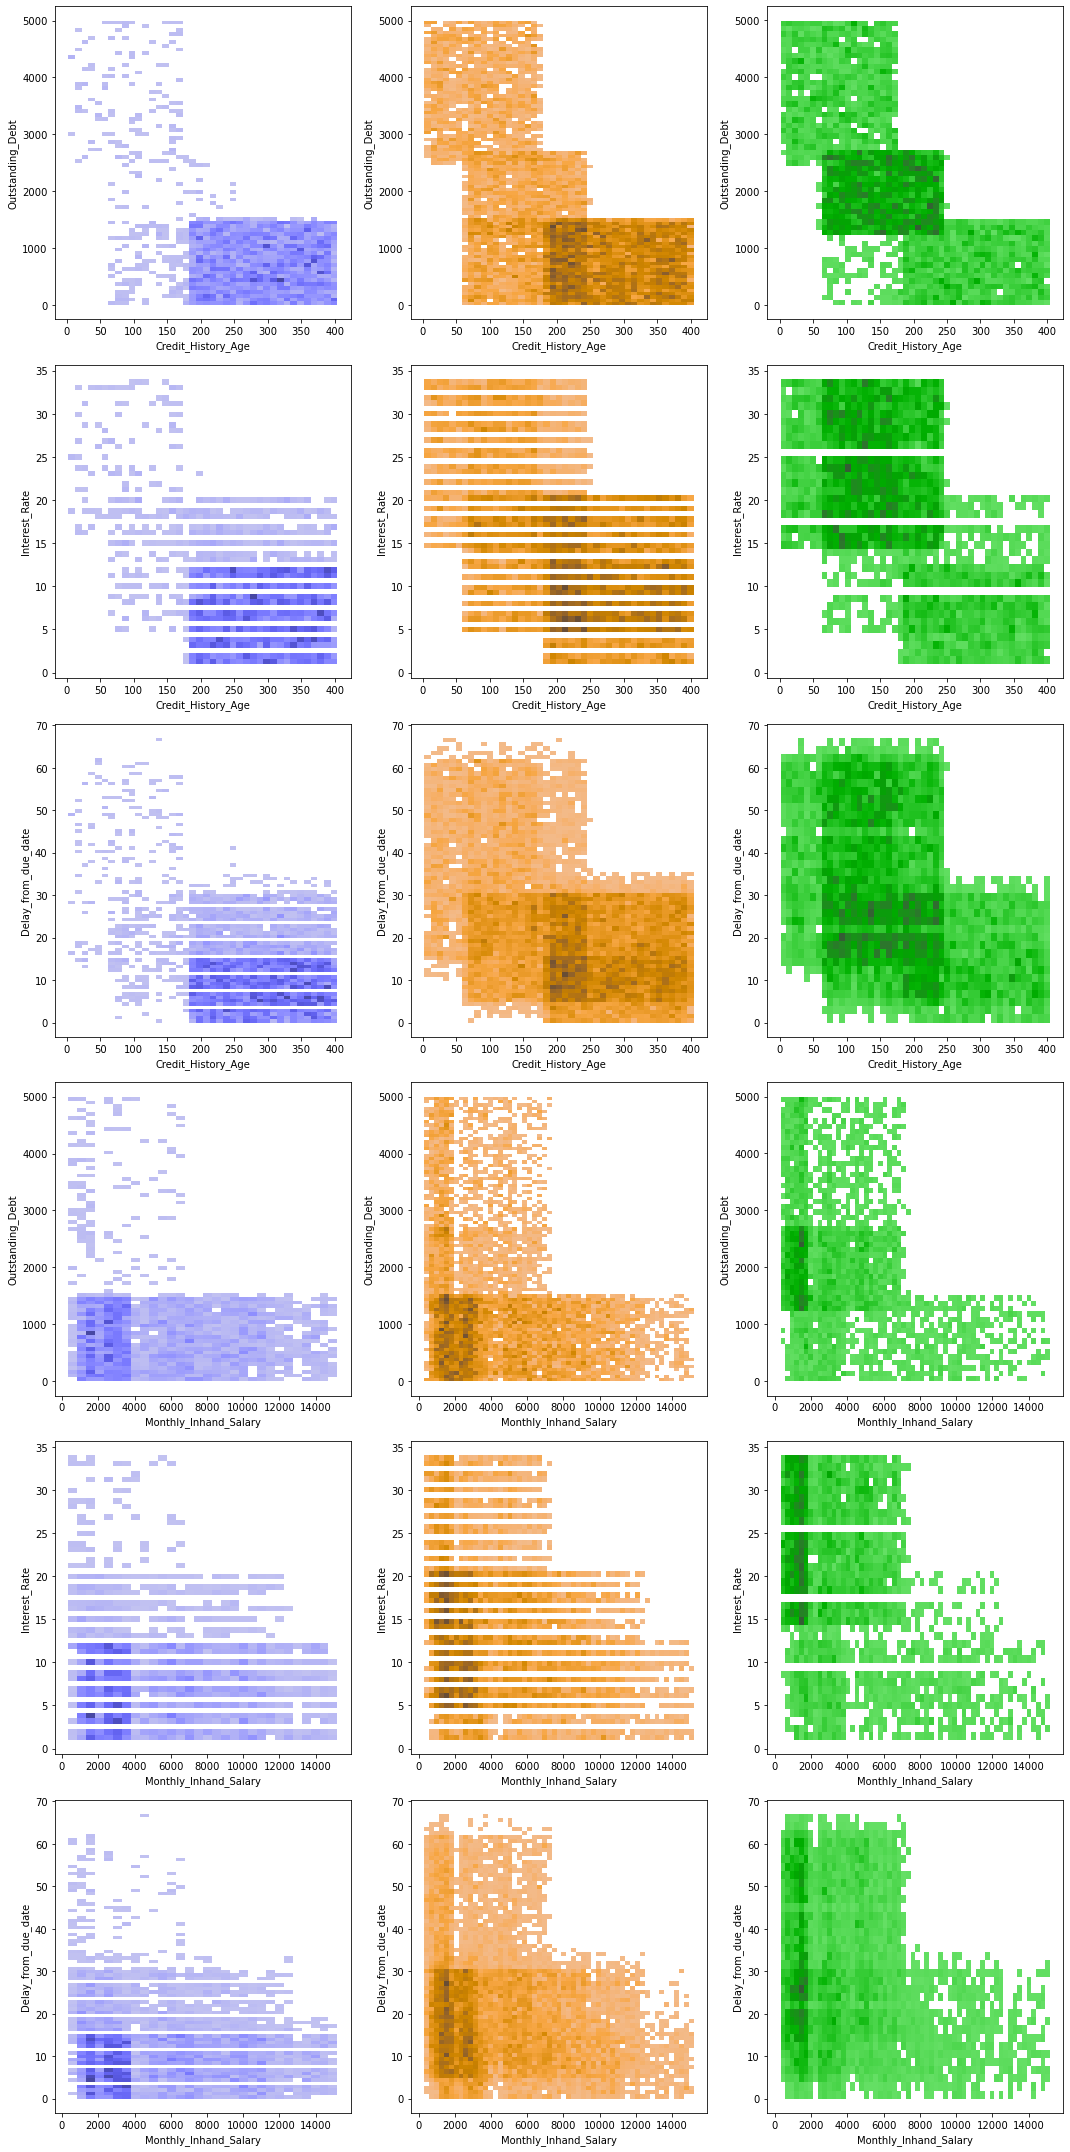

In [12]:
from itertools import product
arr1=["Credit_History_Age","Monthly_Inhand_Salary"]
arr2=["Outstanding_Debt","Interest_Rate","Delay_from_due_date"]

pairs=list(product(arr1,arr2))

fig,axes=plt.subplots(len(pairs),3,figsize=(15,30))

for i,(x,y) in enumerate(pairs):
    colors=["blue","orange","green"]
    vals=["Good","Standard","Poor"]
    for j,(color,val) in enumerate(zip(colors,vals)):
        ax=axes[i,j]
        inter=data[data["Credit_Score"]==val]
        sns.histplot(x=x,y=y,data=inter,color=color,ax=ax);
    
plt.tight_layout()

Estos gráficos muestran la distribución de densidad de las categorías de puntajes de crédito utilizando un análisis bivariado.
Las zonas de overlapping de instancias son lugares donde las instancias se clasifican incorrectamente en su mayoría. Dado esto, los métodos de aprendizaje basados en ensemble serán los más adecuados, mientras que los modelos lineales serán ineficaces debido a la presencia de relaciones complejas no lineales. Las SVM serán lentas debido al tamaño grande del conjunto de datos y al solapamiento de las instancias.

In [12]:
import pandas as pd
import random

# Read the CSV file
data = pd.read_csv('C:\\Users\\juani\\Downloads\\archive (1)\\train_score.csv')

# Determine the number of rows to delete (one-third of the total rows)
num_rows = len(data)
num_rows_to_delete = num_rows // 3

# Generate a list of random row indices to delete
random.seed(42)  # Set a random seed for reproducibility
rows_to_delete = random.sample(range(num_rows), num_rows_to_delete)

# Delete the selected rows
modified_data = data.drop(rows_to_delete)

# Save the modified data to a new CSV file
modified_data.to_csv('modified_data.csv', index=False)

C:\Users\juani\AppData\Local\Temp\ipykernel_8560\1923828618.py:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:\\Users\\juani\\Downloads\\archive (1)\\train_score.csv')


In [ ]:
import pandas as pd
import random

# Read the CSV file
data = pd.read_csv('your_data.csv')

# Determine the number of rows to delete (one-third of the total rows)
num_rows = len(data)
num_rows_to_delete = num_rows // 3

# Generate a list of random row indices to delete
random.seed(42)  # Set a random seed for reproducibility
rows_to_delete = random.sample(range(num_rows), num_rows_to_delete)

# Delete the selected rows
modified_data = data.drop(rows_to_delete)

# Save the modified data to a new CSV file
modified_data.to_csv('modified_data.csv', index=False)

In [15]:
data=train.copy()
#Categorical Variables
col=["Credit_Mix", "Payment_of_Min_Amount", "Payment_Behaviour", "Type_of_Loan"]
index=data[data["Credit_Mix"]=="_"].index
data.loc[index,"Credit_Mix"]=np.nan
df=data[-data["Credit_Mix"].isna()]
ser=df.groupby("Customer_ID")["Credit_Mix"].agg(st.mode).apply(lambda x:x[0][0])
data.drop("Credit_Mix",axis=1,inplace=True)
data=pd.merge(left=data,right=ser,how="left",left_on="Customer_ID",right_index=True)

index=data[data["Payment_Behaviour"]=="!@9#%8"].index
data.loc[index,"Payment_Behaviour"]=np.nan
df=data[-data["Payment_Behaviour"].isna()]
ser=data.groupby("Customer_ID")["Payment_Behaviour"].agg(st.mode).apply(lambda x:x[0][0])
data.drop("Payment_Behaviour",axis=1,inplace=True)
data=pd.merge(left=data,right=ser,how="left",left_on="Customer_ID",right_index=True)

'''Features that should be of numerical type but are present as categorical 
   variable(object type), we will convert them to numerical type.These variable
   contain mix type, for example Monthly_Balance variable contain float type for 
   index 0:98303 and string type from index 98304:99999'''

cols=['Age','Annual_Income','Num_of_Loan','Num_of_Delayed_Payment','Changed_Credit_Limit',
      'Outstanding_Debt','Amount_invested_monthly','Monthly_Balance']

for col in cols:
    data[col]=data[col].apply(lambda x: x if x is np.nan or not isinstance(x, str) 
                        else x.replace("_","")).replace("",np.nan)
    data[col]=data[col].astype(np.float64)
cols=["Age", "Annual_Income", "Num_Bank_Accounts","Num_Credit_Card", "Interest_Rate",
      "Num_of_Loan", "Monthly_Inhand_Salary","Changed_Credit_Limit","Outstanding_Debt",
      "Total_EMI_per_month"]

for col in cols:
    index=data[data[col]<0].index
    data.loc[index,col]=np.nan
    df=data[-data[col].isna()]
    ser=df.groupby("Customer_ID")[col].agg(st.mode).apply(lambda x:x[0][0])
    data.drop(col,axis=1,inplace=True)
    data=pd.merge(left=data,right=ser,how="left",left_on="Customer_ID",right_index=True)

'''These features can best imputed by same feature values present in customer record for 
   different month,therefore we will use that customer record for imputating missing
   value using ffill and bfill'''

inter=data["Credit_History_Age"].str.split(" ")
data["Credit_History_Age"]=inter.apply(lambda x:x if x is np.nan else int(x[0])*12+int(x[3]))

cols=['Num_of_Delayed_Payment', 'Num_Credit_Inquiries',"Credit_History_Age",
      "Delay_from_due_date"]
for col in cols:
    if col in ['Num_of_Delayed_Payment', 'Num_Credit_Inquiries']:
        index2=data[(data[col]>=30)].index
        data.loc[index2,col]=np.nan
    index1=data[(data[col]<0)].index
    data.loc[index1,col]=np.nan
    data[col]=data.groupby("Customer_ID")[col].transform(lambda x:x.ffill())
    data[col]=data.groupby("Customer_ID")[col].transform(lambda x:x.bfill())

for col in ['Amount_invested_monthly', 'Monthly_Balance']:
    if col in ['Amount_invested_monthly']:
        index2=data[(data[col]==10000.0)].index
        data.loc[index2,col]=np.nan
    index1=data[(data[col]<0)].index
    data.loc[index1,col]=np.nan
    ser=data.groupby("Customer_ID")[col].transform(lambda x:x.median())
    data[col].fillna(ser,inplace=True)

#Redundant variable will be dropped

drop=["ID", "Customer_ID", "Month","Name", "SSN", "Occupation","Type_of_Loan"]
data.drop(columns=drop,axis=1,inplace=True)
data.dropna(axis=0, inplace=True)
data.to_csv("Score.csv",index=False)


c:\Users\juani\.conda\envs\ficnenv\lib\site-packages\pandas\core\groupby\groupby.py:1467: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  f = lambda x: func(x, *args, **kwargs)
c:\Users\juani\.conda\envs\ficnenv\lib\site-packages\pandas\core\groupby\groupby.py:1467: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

In [ ]:
import math

def kmv_model(equity_value, total_debt, risk_free_rate, volatility, time_to_maturity):
    """
    Calculates the probability of default using the KMV model.
    :param equity_value: The market value of equity
    :param total_debt: The face value of total debt outstanding
    :param risk_free_rate: The annual risk-free interest rate
    :param volatility: The annualized volatility of the equity
    :param time_to_maturity: Time to maturity of the debt in years
    :return: The probability of default
    """
    d1 = (math.log(equity_value / total_debt) + (risk_free_rate + (0.5 * volatility ** 2)) * time_to_maturity) / (volatility * math.sqrt(time_to_maturity))
    d2 = d1 - (volatility * math.sqrt(time_to_maturity))
    pd = 1 - norm.cdf(d1) - ((total_debt / equity_value) * norm.cdf(d2))
    return pd

This function calculates the probability of default using the KMV model, which is a structural credit risk model that relates the market value of a firm's assets to its total debt outstanding. The inputs to the model are the market value of equity (equity_value), the face value of total debt outstanding (total_debt), the annual risk-free interest rate (risk_free_rate), the annualized volatility of the equity (volatility), and the time to maturity of the debt in years (time_to_maturity). The function returns the probability of default (pd).

The KMV model uses the Black-Scholes-Merton option pricing model to estimate the probability of default. The function calculates the d1 and d2 parameters using the standard Black-Scholes-Merton formulas, and then uses these to calculate the probability of default using the cumulative distribution function of the standard normal distribution (norm.cdf()).

Note that you will need to import the math module and the norm object from the scipy.stats module for this function to work.

## 1. Modelación de Curva Yield con PCA para Valoración de Riesgo de Mercado


Esta sección veremos cómo los componentes principales calculados en una serie temporal multivariada de curvas de rendimiento para EE.UU. permiten identificar el tipo los tipos de movimientos más comunes  que ocurren en las tasas de interés a diferentes vencimientos. El paper seminal de esta sección es **Litterman, R., & Scheinkman, J. (1991). Common factors affecting bond returns. Journal of fixed income**

### 1.1 Teoría: Curva Yield

In [ ]:
import pandas as pd
import numpy as np
import fredapi
import plotly.express as px

#pip install fredapi
#pip install fred

# load yield curve data for the 10-year Treasury constant maturity rate from FRED
fred = fredapi.Fred(api_key='')
yield_curve_3m = fred.get_series('DTB3', start_date='2010-01-01').dropna()
yield_curve_1y = fred.get_series('DGS1', start_date='2010-01-01').dropna()
yield_curve_2y = fred.get_series('DGS2', start_date='2010-01-01').dropna()
yield_curve_5y = fred.get_series('DGS5', start_date='2010-01-01').dropna()
yield_curve_10y = fred.get_series('DGS10', start_date='2010-01-01').dropna()
yield_curve_20y = fred.get_series('DGS20', start_date='2010-01-01').dropna()
yield_curve = pd.DataFrame({'3m': yield_curve_3m,
                            '1y': yield_curve_1y,
                            '2y': yield_curve_2y,
                            '5y': yield_curve_5y,
                            '10y': yield_curve_10y,
                            '20y': yield_curve_20y}).loc["2000-01-01":].dropna()

In [10]:
import pandas as pd
yield_curve=pd.read_csv("fred_data.csv")
yield_curve["Date"]=pd.to_datetime(yield_curve["Date"])
yield_curve.set_index("Date",inplace=True)

In [12]:
# Veamos la curva en diferentes cortes de tiempo

yield_curve_2010=yield_curve.loc["2010-12-15"]
yield_curve_2020=yield_curve.loc["2020-03-30"]
yield_curve_2023=yield_curve.loc["2023-01-30"]
yield_cross=pd.concat([yield_curve_2010,yield_curve_2020,yield_curve_2023],axis=1)
yield_cross.columns=["2010","2020","2023"]
fig = px.line(yield_cross,title='Yield Curves in Time',markers=True)
fig.show()

In [ ]:
# Veamos el comportamiento Historico de cada nodo
fig = px.line(yield_curve,title='Yield Nodes in Time')
fig.show()

Para el propósito del análisis actual, no será relevante tanto la forma particular que asuma la curva de rendimiento en un determinado día, sino que nos enfocaremos los cambios absolutos entre dos puntos consecutivos en el tiempo. Estos movimientos en la curva resulta útiles no  solo para el análisis del riesgo de interés, sino también para determinar el allocation en un portafolio que podrían aprovechar dichos movimientos.

In [ ]:
#Veamos la correlación de la estructura a plazos de la tasa de interés
yield_curve.corr()

Observamos que la estructura  está altamente correlacionada, en particular, entre tasas de vencimiento cercano. Las cifras en la tabla muestran   que la correlación entre los rendimientos es mayor alrededor de la diagonal principal, lo que significa que las tasas de interés de maturity similar se mueven de manera cercana. Por el contrario, la correlación es más débil entre las tasas de interés de vencimientos mas lejanos.

In [ ]:
#Veamos la correlación de la estructura a plazos de la tasa de interés
fig=px.imshow(yield_curve.corr(), text_auto=True, aspect="auto",color_continuous_scale='RdBu_r')
fig.show()

In [ ]:
#Diferencias dia a dis en puntos basicos
df_basis=yield_curve.diff().dropna()*100

#Estandarizamos y centramos los datos
df_standard=(df_basis-df_basis.mean())/(df_basis.std())
df_standard


In [ ]:
#Create a covariance matrix 
cov_matrix_array = np.array(np.cov(df_standard, rowvar=False))

# Perform eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_array)

# Put data into a DataFrame 
df_eigval = pd.DataFrame({"Eigenvalues":eigenvalues})
df_eigvec = pd.DataFrame(eigenvectors)
df_eigvec.columns=["v1","v2","v3","v4","v5","v6"]
df_eigvec.index=["3m","1y","2y","5y","10y","20y"]
# Veamos el comportamiento Historico de cada nodo
fig = px.line(df_eigvec.iloc[:,0:3],markers=True)
fig.show()

In [ ]:
# Work out explained proportion 
df_eigval["Explained proportion"] = df_eigval["Eigenvalues"] / np.sum(df_eigval["Eigenvalues"])

#Format as percentage
df_eigval

In [ ]:
principal_components = df_basis.dot(eigenvectors)
principal_components.columns=["PC1","PC2","PC3","PC4","PC5","PC6"]
fig = px.line(principal_components.iloc[:,0:3])
fig.show()

In [ ]:
principal_components["slope"]=df_basis["10y"]-df_basis["2y"]


In [ ]:
fig = px.line(principal_components[["PC2","slope"]].iloc[0:100,:])
fig.show()


In [ ]:
# Perform eigendecomposition
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
factors = pca.fit_transform(df_standard)


In [ ]:
factors

In [ ]:
pca.explained_variance_ratio_
pca.singular_values_

In [ ]:
changes

In [ ]:
yield_curve.dropna().isnull().sum()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# example yield curve data for multiple nodes (10 nodes, 8 maturities each)
yield_curves = pd.DataFrame(np.random.randn(8, 10), columns=list('ABCDEFGHIJ'))

In [ ]:
# calculate changes in yield rates for each maturity and node
yields = yield_curves.values
changes = np.diff(yields, axis=0) / yields[:-1, :]

# use PCA to extract level and slope factors
pca = PCA(n_components=2)
factors = pca.fit_transform(changes.T)

# plot time series of slope and level factors
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax[0].plot(factors[:, 0])
ax[0].set_title('Level Factor')
ax[1].plot(factors[:, 1])
ax[1].set_title('Slope Factor')
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Leemos la data de la ruta o repositorio
df = pd.read_csv("spot_curve_uk.csv")
# Select all of the data up to 10 years

df.set_index("Date",inplace=True)
df.head()

### Probit

Cuyo nombre proviene de la abreviación de **probability unit**

Pasaremos a modelar ahora situaciones donde buscamos un indicador o conocer si un resultado se ha dado. Modelaremos entonces probabilidades usando herramientas econometricas para hacer proposiciones probabilisticas acerca de la ocurrencia de estos eventos. 

Así estos modelos a estudiar son inherentemente e intrinsecamente no lineales. Empezaremos así con resultados binarios 

### Models for binary outcomes

Construiremos modelos que relacionan un resultado a un conjunto de factores. Nuestra aproximación buscará analizar cada uno de ellos en el marco general de un modelo de probabilidad:

Prob(event j occurs | **x**) = Prob(Y = j | **x**) = F(relevant effects, parameters, **x**)

Prob(Y = 1| **x**) = Probability that event of interest occurs| **x**,

y, naturalmente, Prob(Y = 0| x) = [1 - Prob(Y = 1| x)] es la probabilidad de que el evento no ocurra. 

$Prob(Y = 1| x) =\int_{-\infty }^{x'B}\phi(t)\mathrm{d} t=\Phi(x'B)$

The question of which distribution to use is a natural one. The logistic distribution
is similar to the normal except in the tails, which are considerably heavier. (It more
closely resembles a t distribution with seven degrees of freedom.) For intermediate
values of xB, the two distributions tend to give very similar probabilities. The
logistic distribution tends to give larger probabilities to Y = 1 when xB is extremely
small (and smaller probabilities to Y = 1 when xB is very large) than the normal
distribution. It is difficult to provide practical generalities on this basis, however,
as they would require knowledge of B. We might expect different predictions from
the two models, however, if the sample contains (1) very few responses (Y’s equal
to 1) or very few nonresponses (Y’s equal to 0) and (2) very wide variation in an
important independent variable, particularly if (1) is also true. There are practical
reasons for favoring one or the other in some cases for mathematical convenience, but
it is difficult to justify the choice of one distribution or another on theoretical grounds.
Amemiya (1981) discusses a number of related issues, but as a general proposition,
the question is unresolved. In most applications, the choice between these two seems
not to make much difference.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.tools as sm
from statsmodels.discrete.discrete_model import Probit
data = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/carData/Mroz.csv')

In [ ]:
data = data.drop(data.columns[0], axis = 1)
data["lfp"] = data["lfp"] == "yes"
data["wc"] = data["wc"] == "yes"
data["hc"] = data["hc"] == "yes"

In [ ]:
Y = data["lfp"]
X = data.drop(["lfp"], 1)
X = sm.add_constant(X)
model = Probit(Y, X.astype(float))
probit_model = model.fit()
print(probit_model.summary())

In [ ]:
mfx = probit_model.get_margeff(at="all")
#print(mfx.summary())
mfx

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
np.random.seed(0)
nobs = 100
#x1 = c
x2 = np.random.normal(size=nobs)

# Add small amount of random noise to the predictors to avoid perfect separation
x1 = np.random.normal(size=nobs)+ np.random.normal(scale=0.1, size=nobs)
x2 =  np.random.normal(scale=0.1, size=nobs)

X = sm.add_constant(np.column_stack((x1, x2)))
y = (x1 + x2 > 0)

# Fit the logit model
model = sm.Logit(y, X).fit()

# Define the range of x values for which to calculate the predictions
x_vals = np.linspace(x1.min(), x1.max(), 100)

# Calculate the marginal effect of x1 at the mean of x2
mean_x2 = x2.mean()
x_grid = np.column_stack((x_vals, np.repeat(mean_x2, 100)))
predict_mean_x2 = model.predict(exog=x_grid)

# Plot the marginal effect of x1 at the mean of x2
plt.plot(x_vals, predict_mean_x2)
plt.xlabel('x1')
plt.ylabel('P(y=1)')
plt.title('Marginal Effect of x1 at the Mean of x2')
plt.show()